In [82]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 0 #June 22nd, 2023
current_version = 1 #June 28nd, 2023
current_version = 2 #July 27nd, 2023
current_version = 3 #Sept 15th, 2023
current_version = 4 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

# Load Data

In [61]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for DS_19
Fetching files for DS_22
Fetching files for DS_23
Fetching files for DS_24
Fetching files for DS_27
Fetching files for DS_28
Fetching files for DS_13
Fetching files for BS_173
Fetching files for BS_175
Fetching files for BS_187
Fetching files for BS_188
Fetching files for BS_213
Fetching files for BS_214
Fetching files for TH_217
Fetching files for AE_235
Fetching files for AE_236
Fetching files for TH_237
Fetching files for AE_252
Fetching files for AE_254
Fetching files for AE_238
Fetching files for AE_239
Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
ERROR: MULTIPLE REVERSALS IN ANIMAL BS_179
P:\Behavioor\BS_191\behavior\BS_191_1v2.txt

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

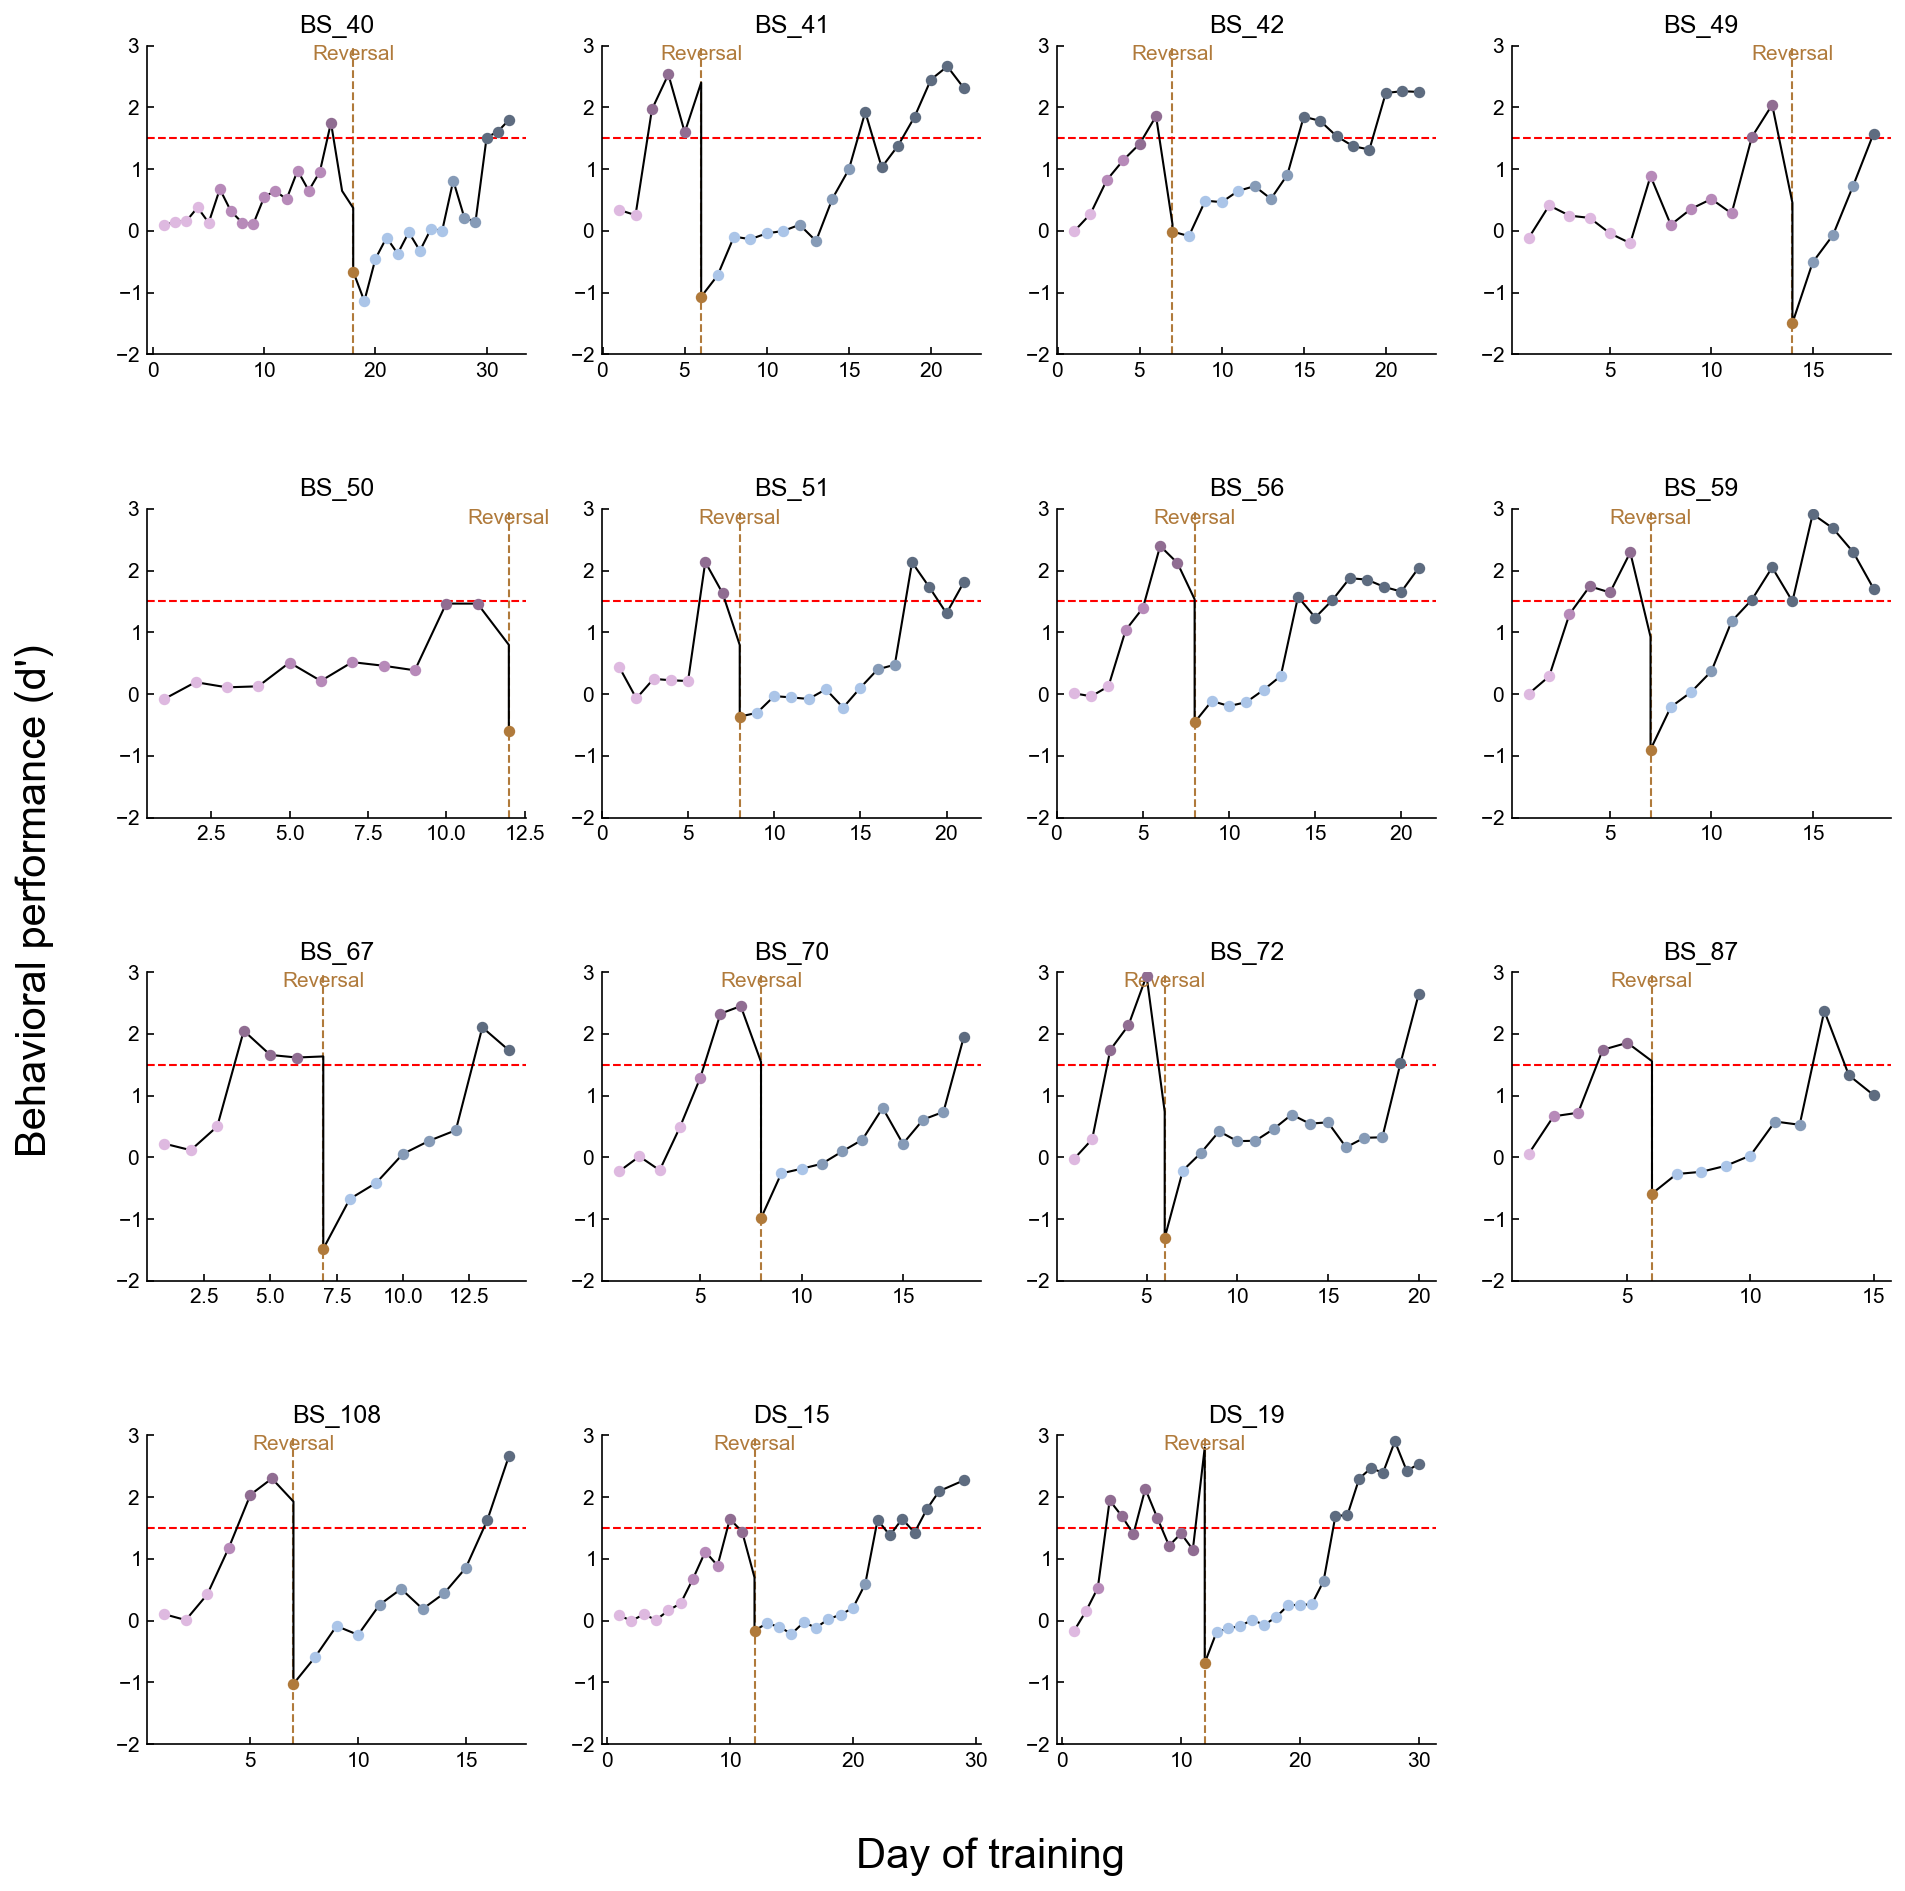

In [62]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [63]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 723/723 [00:14<00:00, 49.60it/s]


In [64]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1830/1830 [00:55<00:00, 32.69it/s]

errors for: []


# Load Decoding Data

In [65]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,passive_df,choice_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [66]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1830it [00:09, 200.68it/s]


In [67]:
def get_TE_mask(acc,pval_s):#,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    #is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s)#,pval_stim_c)
is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s)#,pval_choice_c)

Task encoder threshold: 0.55951845
Task encoder threshold: 0.593702839530461


In [68]:
#Task encoder threshold: 0.55951845

In [60]:
a = (np.greater(stim_acc,task_encoder_threshold_s))
print(np.sum(a))

486


In [20]:
b = (np.less_equal(pval_stim_s,0.05))
print(np.sum(b))

1162


In [41]:
print(np.sum(np.logical_and(a,b)))

485


In [75]:
CR_threshold = 3.5

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    cells_in_phase = 0
    te_in_phase = 0
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        if EILphases[idx] != phase:
            continue
            
        sessionfile = ilep.loadSessionCached(act_directory,session)        
            
        acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
        acc2 = stim_acc[idx]
        if acc != acc2 and np.isfinite(acc) and np.isfinite(acc2):
            print(f"session {session} cluster {clust} has accs {acc} and {acc2}")
        pval = pval_stim_s[idx]
#         if acc < task_encoder_threshold_s or pval > 0.05:
#             continue
        
        is_TE_here = is_TE_s[idx]
        is_TE_there = acc2>=task_encoder_threshold_s and pval<0.05
        if is_TE_here != is_TE_there:
            print(f"session {session} cluster {clust} has evaluations {is_TE_here} and {is_TE_there}")
    
#         #Require >= 100 trials
#         conditions = ilep.getAllConditions(sessionfile,clust)
#         if len(conditions['all_trials'].trials) < 100:
#             pass#continue
        if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
            continue
            
        try:
            this_rampMod = np.abs(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        except Exception as e:
            print(e)
            this_rampMod = np.nan
        if np.isnan(this_rampMod):
            continue
            
        if this_rampMod < CR_threshold:
            if is_TE_s[idx]:
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_rampMod >= CR_threshold:
            if is_TE_s[idx]:
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE_s[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
    
    print(f"{phase} has {CR_te_in_phase} CR TEs, {NCR_te_in_phase} NCR TEs, and {(np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))} total cells")

1830it [00:05, 351.77it/s]
0it [00:00, ?it/s]

pre early has 30 CR TEs, 7 NCR TEs, and 148 total cells


1830it [00:06, 287.21it/s]
84it [00:00, 792.28it/s]

pre late has 27 CR TEs, 24 NCR TEs, and 187 total cells


1830it [00:02, 822.65it/s] 
47it [00:00, 465.24it/s]

pre expert has 32 CR TEs, 18 NCR TEs, and 97 total cells


1830it [00:19, 95.13it/s] 
161it [00:00, 1476.74it/s]

post early has 79 CR TEs, 35 NCR TEs, and 349 total cells


1830it [00:07, 235.52it/s]
175it [00:00, 1682.31it/s]

post late has 49 CR TEs, 67 NCR TEs, and 299 total cells


1830it [00:05, 308.14it/s] 

post expert has 45 CR TEs, 48 NCR TEs, and 268 total cells


In [76]:
485

485

In [77]:
619

619

In [78]:
np.sum(is_TE_s)

485

In [48]:
TEs = 0
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
        
    acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    acc2 = stim_acc[idx]
    if acc != acc2 and np.isfinite(acc) and np.isfinite(acc2):
        print(f"session {session} cluster {clust} has accs {acc} and {acc2}")
    pval = pval_stim_s[idx]

    is_TE_here = is_TE_s[idx]
    is_TE_there = acc2>=task_encoder_threshold_s and pval<0.05
    if is_TE_here != is_TE_there:
        print(f"session {session} cluster {clust} has evaluations {is_TE_here} and {is_TE_there}")
        
    if is_TE_here:
        TEs += 1

1830it [01:11, 25.77it/s]


In [49]:
TEs

461

In [40]:
animals

array(['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56',
       'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15',
       'DS_19'], dtype='<U6')

## V2

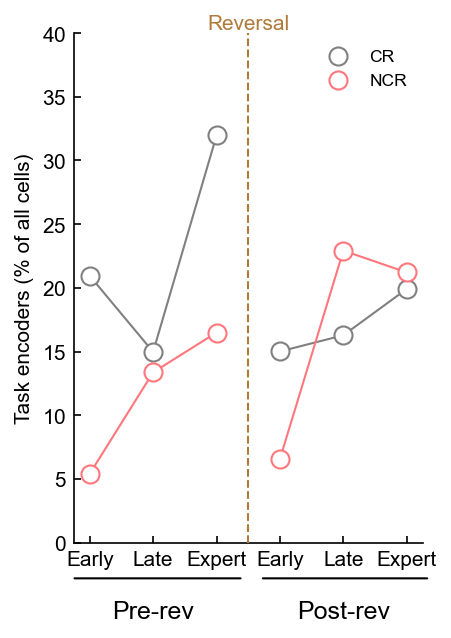

In [30]:
fig, ax = plt.subplots(figsize=(3,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

#ax.set_ylim([0,35])
ax.set_ylim([0,40])
ax.set_yticks([0,5,10,15,20,25,30,35,40])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.5
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR-NCR Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

## V3

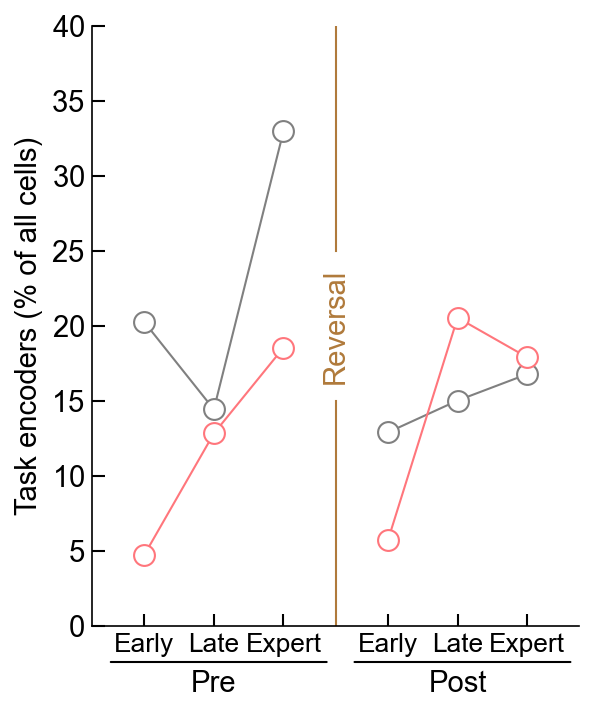

In [32]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

ax.plot(np.array([0,1,2])-switch_offset,CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot(np.array([3,4,5])+switch_offset,CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=100,label='CR')

ax.plot(np.array([0,1,2])-switch_offset,NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot(np.array([3,4,5])+switch_offset,NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=100,label='NCR')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,40])
ax.set_yticks([0,5,10,15,20,25,30,35,40])
ylab = ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR-NCR Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

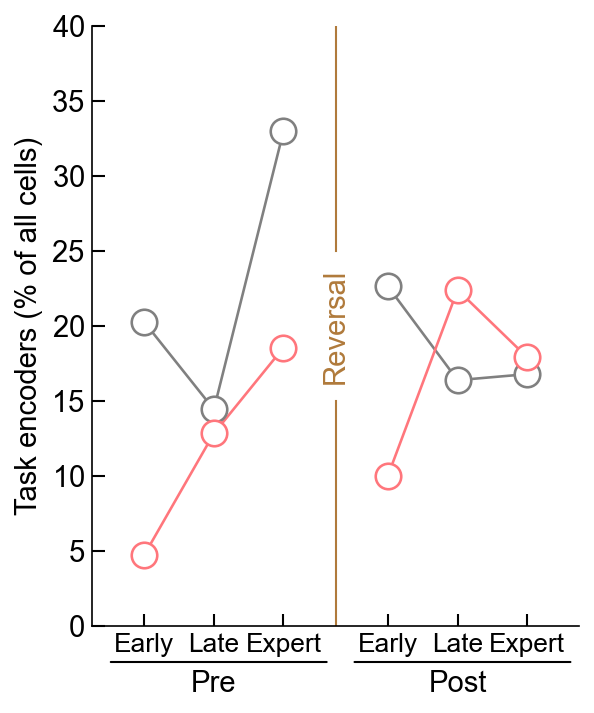

In [84]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

ax.plot(np.array([0,1,2])-switch_offset,CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1.25)
ax.plot(np.array([3,4,5])+switch_offset,CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1.25)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=150,label='CR',lw=1.25)

ax.plot(np.array([0,1,2])-switch_offset,NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1.25)
ax.plot(np.array([3,4,5])+switch_offset,NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1.25)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=150,label='NCR',lw=1.25)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,40])
ax.set_yticks([0,5,10,15,20,25,30,35,40])
ylab = ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR-NCR Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [80]:
BOTH_allpc_task_encoders = CR_allpc_task_encoders + NCR_allpc_task_encoders

## V2

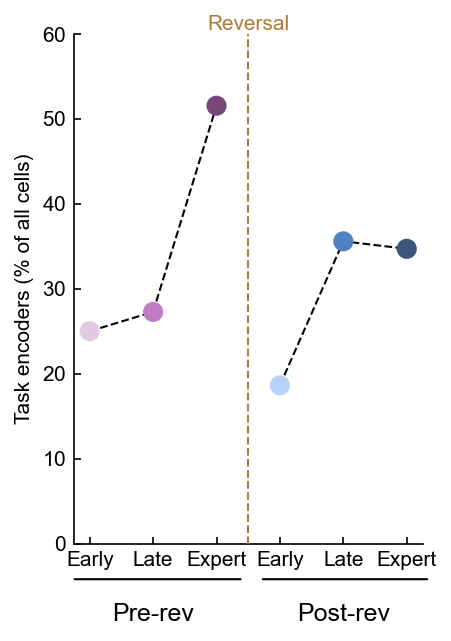

In [29]:
fig, ax = plt.subplots(figsize=(3,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.plot([3,4,5],BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.scatter(range(6),BOTH_allpc_task_encoders*100,fc=PHASE_COLORS,ec=PHASE_COLORS,s=75,label='Stim-only CR')

#ax.set_ylim([0,35])
ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.5
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

## V3

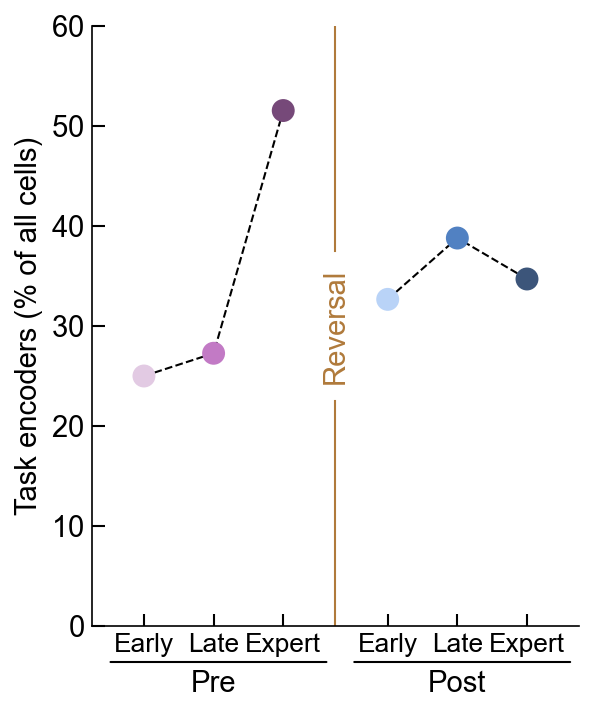

In [81]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

ax.plot(np.array([0,1,2])-switch_offset,BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.plot(np.array([3,4,5])+switch_offset,BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,BOTH_allpc_task_encoders*100,fc=PHASE_COLORS,ec=PHASE_COLORS,s=100,label='Stim-only CR')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ylab = ax.set_ylabel('Task encoders (% of all cells)')


ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

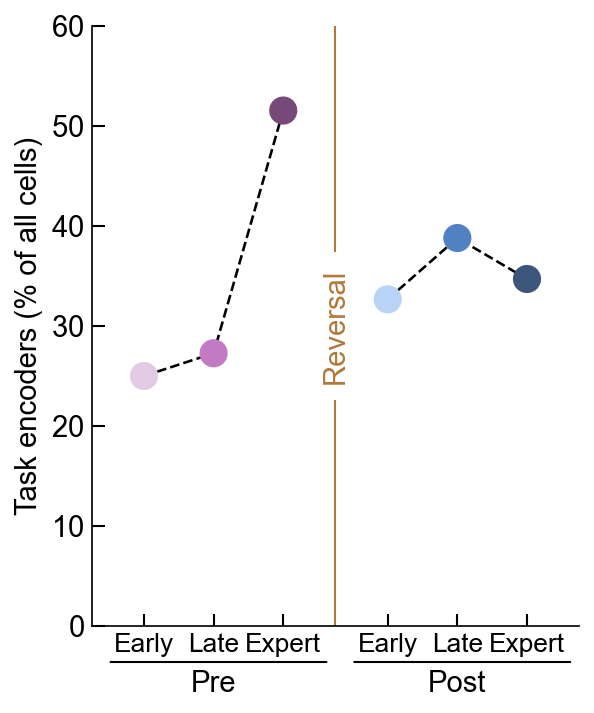

In [86]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25

################################################################################################################

ax.plot(np.array([0,1,2])-switch_offset,BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1.25)
ax.plot(np.array([3,4,5])+switch_offset,BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1.25)
ax.scatter(np.array(range(6))+np.array([-1,-1,-1,1,1,1])*switch_offset,BOTH_allpc_task_encoders*100,fc=PHASE_COLORS,ec=PHASE_COLORS,s=150,label='Stim-only CR',lw=1.25)

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ylab = ax.set_ylabel('Task encoders (% of all cells)')


ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Stimulus Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

# Stats per animal

In [42]:
CR_threshold = 3.5

stats_NCR_allpc_task_encoders = [[],[],[],[],[],[]]
stats_CR_allpc_task_encoders = [[],[],[],[],[],[]]
stats_BOTH_allpc_task_encoders = [[],[],[],[],[],[]]

for animal in animals:
    print(animal)
    
    animal_NCR_allpc_task_encoders = np.array([np.nan]*6)
    animal_CR_allpc_task_encoders = np.array([np.nan]*6)
    
    phases = ['pre early','pre late','pre expert','post early','post late','post expert']
    for phase_idx,phase in enumerate(phases):

        cells_in_phase = 0
        te_in_phase = 0
        CR_te_in_phase = 0
        CR_cells_in_phase = 0
        NCR_te_in_phase = 0
        NCR_cells_in_phase = 0

        for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
            sessionfile = ilep.loadSessionCached(act_directory,session)
            
            if sessionfile.meta.animal != animal:
                continue

            if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
                continue
            if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
                continue
            if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
                continue
            if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
                continue
            if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
                continue
            if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
                continue
            if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
                continue

            if EILphases[idx] != phase:
                continue

            acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')

            if np.isnan(acc):
                pass#continue

            #Require >= 100 trials
            conditions = ilep.getAllConditions(sessionfile,clust)
            if len(conditions['all_trials'].trials) < 100:
                pass#continue

            try:
                this_rampMod = np.abs(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
            except Exception as e:
                print(e)
                this_rampMod = np.nan
            if np.isnan(this_rampMod):
                continue

            if this_rampMod < CR_threshold:
                if is_TE_s[idx]:
                    NCR_te_in_phase += 1
                NCR_cells_in_phase += 1
            elif this_rampMod >= CR_threshold:
                if is_TE_s[idx]:
                    CR_te_in_phase += 1
                CR_cells_in_phase += 1

            cells_in_phase += 1
            if is_TE_s[idx]:
                te_in_phase += 1

        animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
        animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
        
        stats_CR_allpc_task_encoders[phase_idx].append(animal_CR_allpc_task_encoders[phase_idx])
        stats_NCR_allpc_task_encoders[phase_idx].append(animal_NCR_allpc_task_encoders[phase_idx])
        stats_BOTH_allpc_task_encoders[phase_idx].append(animal_CR_allpc_task_encoders[phase_idx]+animal_NCR_allpc_task_encoders[phase_idx])

11it [00:00, 87.28it/s]

BS_40


1830it [00:28, 64.06it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:32, 56.41it/s] 
1830it [00:28, 63.72it/s] 
1830it [00:29, 63.03it/s] 
1830it [00:28, 63.15it/s] 
1830it [00:29, 62.37it/s] 
13it [00:00, 93.95it/s]

BS_41


1830it [00:28, 64.69it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 64.58it/s] 
1830it [00:28, 64.28it/s] 
1830it [00:29, 61.74it/s] 
1830it [00:29, 62.07it/s] 
1830it [00:28, 64.28it/s] 
12it [00:00, 74.05it/s]

BS_42


1830it [00:28, 65.03it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 64.90it/s] 
1830it [00:28, 65.00it/s] 
1830it [00:31, 58.30it/s] 
1830it [00:29, 61.37it/s] 
1830it [00:28, 63.12it/s] 
13it [00:00, 98.46it/s]

BS_49


1830it [00:32, 56.71it/s] 
1830it [00:29, 61.66it/s] 
1830it [00:28, 63.55it/s] 
1830it [00:28, 63.70it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 63.95it/s] 
1830it [00:29, 62.66it/s] 
0it [00:00, ?it/s]

BS_50


1830it [00:30, 60.77it/s] 
1830it [00:29, 62.57it/s] 
1830it [00:28, 63.81it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 63.95it/s] 
1830it [00:28, 64.29it/s] 
1830it [00:28, 63.32it/s] 
13it [00:00, 101.54it/s]

BS_51


1830it [00:28, 63.34it/s] 
1830it [00:28, 63.71it/s] 
1830it [00:28, 63.56it/s] 
1830it [00:28, 63.73it/s] 
1830it [00:28, 63.52it/s] 
1830it [00:28, 63.21it/s] 
13it [00:00, 94.87it/s]

BS_56


1830it [00:28, 64.28it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 64.56it/s] 
1830it [00:28, 64.84it/s] 
1830it [00:28, 63.96it/s] 
1830it [00:28, 64.85it/s] 
1830it [00:28, 63.47it/s] 
11it [00:00, 87.28it/s]

BS_59


1830it [00:28, 64.92it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:28, 64.81it/s] 
1830it [00:28, 64.75it/s] 
1830it [00:28, 64.70it/s] 
1830it [00:28, 64.87it/s] 
1830it [00:28, 64.64it/s] 
13it [00:00, 102.34it/s]

BS_67


1830it [00:28, 65.08it/s] 
1830it [00:28, 64.56it/s] 
1830it [00:28, 65.01it/s] 
1830it [00:28, 63.86it/s] 
1830it [00:28, 63.71it/s] 
1830it [00:29, 62.91it/s] 
13it [00:00, 101.11it/s]

BS_70


1830it [00:28, 63.18it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:30, 60.02it/s] 
1830it [00:29, 61.16it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:30, 59.68it/s] 
1830it [00:3

BS_72


1830it [00:29, 62.01it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:29, 62.82it/s] 
1830it [00:30, 60.60it/s] 
1830it [00:30, 59.87it/s] 
1830it [00:31, 57.78it/s] 
1830it [00:29, 61.82it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_c

BS_87


1830it [00:29, 61.80it/s] 
1830it [00:29, 61.92it/s] 
1830it [00:30, 59.53it/s] 
1830it [00:33, 55.16it/s] 
1830it [00:30, 59.93it/s] 
1830it [00:30, 60.94it/s] 
13it [00:00, 96.27it/s]

BS_108


1830it [00:29, 61.46it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:29, 62.09it/s] 
1830it [00:28, 63.68it/s] 
1830it [00:29, 62.67it/s] 
1830it [00:29, 62.81it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_ce

DS_15


1830it [00:28, 63.82it/s] 
1830it [00:29, 62.80it/s] 
1830it [00:29, 61.35it/s] 
1479it [00:22, 121.62it/s]

3
21
22
23
28
30
37


1492it [00:23, 69.39it/s] 

39
43
54
56
58
65
67
89
90
92
95
99
3
5


1502it [00:23, 54.90it/s]

19
20
21
18
37
38
0


1510it [00:23, 47.66it/s]

8
9
19
25
26
32
37


1517it [00:24, 42.71it/s]

39
47
53
58
64
69
70


1523it [00:24, 39.86it/s]

73
3
13
15
28
42
74


1533it [00:24, 36.84it/s]

0
6
7
9
16
21
22


1541it [00:24, 34.81it/s]

28
31
38
36
45
55
69


1545it [00:25, 34.03it/s]

77
97
100
116
117
121
127


1553it [00:25, 32.93it/s]

129
134
135
138
141
148
153


1577it [00:25, 73.21it/s]

161
166


1830it [00:31, 58.30it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1287it [00:21, 80.72it/s] 

2
11
12
20
26
35
44


1296it [00:21, 59.26it/s]

46
63
79
83
84
97
101


1304it [00:22, 48.77it/s]

103
104
105
107
109
115
122


1320it [00:22, 50.78it/s]

123
137
138
140


1830it [00:30, 60.88it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1314it [00:23, 101.86it/s]

1
4
6
8
17
19
22


1325it [00:23, 57.30it/s] 

31
32
42
47
48
60
9
11
12
20
25
34


1334it [00:24, 44.21it/s]

41
42
60
65
67
69


1341it [00:24, 38.81it/s]

70
79
80
84
86
93


1347it [00:24, 35.19it/s]

98
99
102
105
111


1352it [00:24, 32.06it/s]

112
113


1830it [00:36, 50.18it/s] 
13it [00:00, 93.50it/s]

DS_19


1830it [00:32, 56.97it/s] 
<ipython-input-42-8119d5cfc9ed>:78: RuntimeWarning: invalid value encountered in long_scalars
  animal_CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
<ipython-input-42-8119d5cfc9ed>:79: RuntimeWarning: invalid value encountered in long_scalars
  animal_NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))
1830it [00:30, 59.23it/s] 
1830it [00:35, 51.85it/s] 
1830it [00:40, 45.44it/s] 
1830it [00:34, 52.71it/s] 
1830it [00:36, 50.63it/s] 


In [53]:
stats_CR_allpc_task_encoders = [ilep.rmnan(d) for d in stats_CR_allpc_task_encoders]
stats_NCR_allpc_task_encoders = [ilep.rmnan(d) for d in stats_NCR_allpc_task_encoders]
stats_BOTH_allpc_task_encoders = [ilep.rmnan(d) for d in stats_BOTH_allpc_task_encoders]

In [54]:
[np.mean(d) for d in stats_BOTH_allpc_task_encoders]

[0.35322793148880105,
 0.23878205128205127,
 0.523015873015873,
 0.28067505910015667,
 0.3594400100989154,
 0.3254540671533687]

In [48]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(stats_BOTH_allpc_task_encoders[0])
data_dec.prelate = np.abs(stats_BOTH_allpc_task_encoders[1])
data_dec.preexpert = np.abs(stats_BOTH_allpc_task_encoders[2])
data_dec.postearly = np.abs(stats_BOTH_allpc_task_encoders[3])
data_dec.postlate = np.abs(stats_BOTH_allpc_task_encoders[4])
data_dec.postexpert = np.abs(stats_BOTH_allpc_task_encoders[5])
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.210745   3.0  0.070248  1.794187  0.162576  0.111250
1          context  0.036218   1.0  0.036218  0.925029  0.341536  0.021059
2  phase * context  0.061652   3.0  0.020551  0.524875  0.667526  0.035326
3         Residual  1.683593  43.0  0.039153       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.590646  0.787527 -0.218128
8     post-late  baseline  experimental  0.469395  0.787527 -0.371442
9    pre-expert  baseline  experimental  0.462343  0.787527 -0.862527
10     pre-late  baseline  experimental  0.800000  0.800000  0.401577


In [49]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(stats_CR_allpc_task_encoders[0])
data_dec.prelate = np.abs(stats_CR_allpc_task_encoders[1])
data_dec.preexpert = np.abs(stats_CR_allpc_task_encoders[2])
data_dec.postearly = np.abs(stats_CR_allpc_task_encoders[3])
data_dec.postlate = np.abs(stats_CR_allpc_task_encoders[4])
data_dec.postexpert = np.abs(stats_CR_allpc_task_encoders[5])
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.226066   3.0  0.075355  3.420325  0.025485  0.192655
1          context  0.005918   1.0  0.005918  0.268594  0.606933  0.006208
2  phase * context  0.040886   3.0  0.013629  0.618592  0.606766  0.041372
3         Residual  0.947360  43.0  0.022032       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.900776  0.900776  0.075846
8     post-late  baseline  experimental  0.332944  0.665888  0.194113
9    pre-expert  baseline  experimental  0.500000  0.666667 -0.421504
10     pre-late  baseline  experimental  0.266667  0.665888  1.097793


In [50]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(stats_NCR_allpc_task_encoders[0])
data_dec.prelate = np.abs(stats_NCR_allpc_task_encoders[1])
data_dec.preexpert = np.abs(stats_NCR_allpc_task_encoders[2])
data_dec.postearly = np.abs(stats_NCR_allpc_task_encoders[3])
data_dec.postlate = np.abs(stats_NCR_allpc_task_encoders[4])
data_dec.postexpert = np.abs(stats_NCR_allpc_task_encoders[5])
ilep.nonparametricIndependentStatsCompareToOwnEarly(data_dec)
pass

            Source        SS    DF        MS         F     p-unc       np2
0            phase  0.023601   3.0  0.007867  0.430947  0.731885  0.029188
1          context  0.071415   1.0  0.071415  3.911980  0.054374  0.083390
2  phase * context  0.009536   3.0  0.003179  0.174122  0.913323  0.012002
3         Residual  0.784985  43.0  0.018255       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.770514  0.814337 -0.388198
8     post-late  baseline  experimental  0.161646  0.646583 -0.821082
9    pre-expert  baseline  experimental  0.666667  0.814337 -0.554828
10     pre-late  baseline  experimental  0.814337  0.814337 -0.211196


In [42]:
CR_threshold = 0.5

NCR_pc_task_encoders = np.array([np.nan]*6)
CR_pc_task_encoders = np.array([np.nan]*6)
NCR_allpc_task_encoders = np.array([np.nan]*6)
CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre expert']#['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    cells_in_phase = 0
    te_in_phase = 0
    CR_te_in_phase = 0
    CR_cells_in_phase = 0
    NCR_te_in_phase = 0
    NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(sessionfile,clust)
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        this_rampMod = np.abs(sessionfile.responsiveness[clust]['all_trials'].rampingModNorm)
        if np.isnan(this_rampMod):
            continue
            
        if this_rampMod < CR_threshold:
            if is_TE_c[idx]:
                print(f"NCR: {idx}")
                NCR_te_in_phase += 1
            NCR_cells_in_phase += 1
        elif this_rampMod >= CR_threshold:
            if is_TE_c[idx]:
                print(f"CR: {idx}")
                CR_te_in_phase += 1
            CR_cells_in_phase += 1
            
        cells_in_phase += 1
        if is_TE_c[idx]:
            te_in_phase += 1
    
    CR_pc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase))
    NCR_pc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase))
    
    CR_allpc_task_encoders[phase_idx] = np.sum(CR_te_in_phase) / (np.sum(CR_cells_in_phase)+np.sum(NCR_cells_in_phase))
    NCR_allpc_task_encoders[phase_idx] = np.sum(NCR_te_in_phase) / (np.sum(NCR_cells_in_phase)+np.sum(CR_cells_in_phase))

8it [00:00, 31.77it/s]

NCR: 1
NCR: 2


667it [00:09, 90.70it/s] 

NCR: 663


1150it [00:14, 171.73it/s]

CR: 1156
NCR: 1157
CR: 1158
CR: 1159
CR: 1161
CR: 1162


1383it [00:18, 111.74it/s]

CR: 1382
NCR: 1384


1404it [00:19, 42.24it/s] 

NCR: 1400


1467it [00:19, 99.54it/s]

NCR: 1467
CR: 1472


1682it [00:24, 67.90it/s]


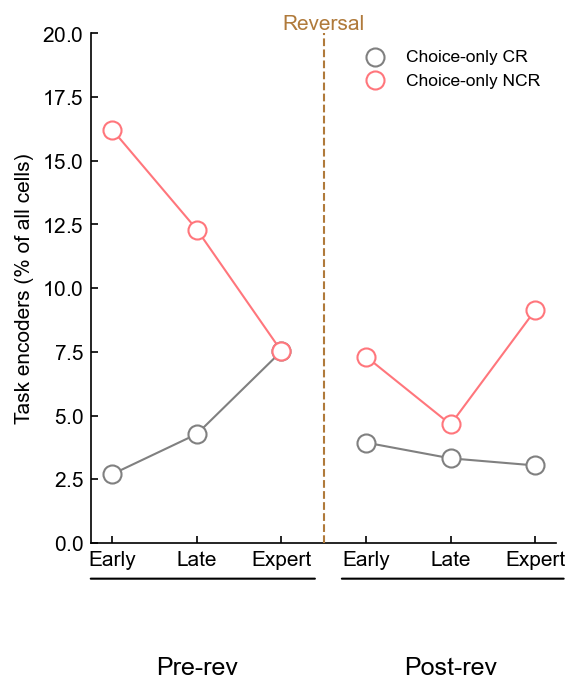

In [34]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='Choice-only CR')

ax.plot([0,1,2],NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='Choice-only NCR')

#ax.set_ylim([0,35])
ax.set_ylim([0,20])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -4.434885432994318, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -4.434885432994318, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR-NCR Choice Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [40]:
CR_allpc_task_encoders[2]

0.07526881720430108

In [41]:
NCR_allpc_task_encoders[2]

0.07526881720430108

In [44]:
7/0.075

93.33333333333334

# Passive decoding

In [10]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 723/723 [00:05<00:00, 141.98it/s]


In [11]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
passive_FRmod_preearly = []
passive_FRmod_prelate = []
passive_FRmod_preexpert = []
passive_FRmod_postearly = []
passive_FRmod_postlate = []
passive_FRmod_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [12]:
passive_EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = ACsessionfile.meta.animal
        day = ACsessionfile.meta.day_of_training

        if ACsessionfile.meta.day_of_training <= pre_early:
            passive_EILphases[idx] = 'pre early'
        elif ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
            passive_EILphases[idx] = 'pre late'
        elif ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
            passive_EILphases[idx] = 'pre expert'

        elif ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
            passive_EILphases[idx] = 'post early'
        elif ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
            passive_EILphases[idx] = 'post late'
        elif ACsessionfile.meta.day_of_training >= post_expert:
            passive_EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(ACsessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1830/1830 [00:12<00:00, 143.99it/s]

errors for: []


In [13]:
preearly_animal = []
prelate_animal = []
preexpert_animal = []
postearly_animal = []
postlate_animal = []
postexpert_animal = []

pre_early_session = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_FRmod_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_animal.append(ACsessionfile.meta.animal)
        pre_early_session.append(session)
#         print(ACsessionfile.meta.files)
#         print(ACsessionfile.meta.directory)
#         print()
        if ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation < 1:
            print(f"{session} clust {clust} is an NCR")
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_FRmod_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_FRmod_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_FRmod_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_FRmod_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_FRmod_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_animal.append(ACsessionfile.meta.animal)
    

665it [00:04, 243.48it/s]

TH_201_1_passive_AC.pickle clust 89 is an NCR
TH_201_1_passive_AC.pickle clust 201 is an NCR


692it [00:04, 197.05it/s]

TH_201_2_passive_AC.pickle clust 74 is an NCR
TH_201_2_passive_AC.pickle clust 167 is an NCR
TH_201_2_passive_AC.pickle clust 204 is an NCR


715it [00:04, 172.51it/s]

TH_201_2_passive_AC.pickle clust 231 is an NCR
TH_201_3_passive_AC.pickle clust 72 is an NCR
TH_201_3_passive_AC.pickle clust 76 is an NCR
TH_201_3_passive_AC.pickle clust 127 is an NCR


753it [00:04, 155.10it/s]

TH_201_3_passive_AC.pickle clust 154 is an NCR
TH_201_3_passive_AC.pickle clust 169 is an NCR
TH_201_3_passive_AC.pickle clust 229 is an NCR
TH_201_3_passive_AC.pickle clust 230 is an NCR


815it [00:05, 180.54it/s]

TH_201_4_passive_AC.pickle clust 70 is an NCR
TH_201_4_passive_AC.pickle clust 79 is an NCR
TH_201_4_passive_AC.pickle clust 224 is an NCR


853it [00:05, 168.42it/s]

TH_203_1_passive_AC.pickle clust 121 is an NCR
TH_203_1_passive_AC.pickle clust 191 is an NCR
TH_203_1_passive_AC.pickle clust 228 is an NCR
TH_203_1_passive_AC.pickle clust 278 is an NCR
TH_203_1_passive_AC.pickle clust 296 is an NCR
TH_203_1_passive_AC.pickle clust 336 is an NCR
TH_203_1_passive_AC.pickle clust 348 is an NCR
TH_203_1_passive_AC.pickle clust 357 is an NCR
TH_203_1_passive_AC.pickle clust 376 is an NCR
TH_203_2_passive_AC.pickle clust 24 is an NCR
TH_203_2_passive_AC.pickle clust 75 is an NCR
TH_203_2_passive_AC.pickle clust 80 is an NCR


922it [00:05, 205.75it/s]

TH_203_2_passive_AC.pickle clust 240 is an NCR
TH_203_2_passive_AC.pickle clust 253 is an NCR
TH_203_3_passive_AC.pickle clust 27 is an NCR
TH_203_4_passive_AC.pickle clust 38 is an NCR
TH_203_4_passive_AC.pickle clust 46 is an NCR
TH_203_4_passive_AC.pickle clust 87 is an NCR
TH_203_4_passive_AC.pickle clust 88 is an NCR
TH_203_4_passive_AC.pickle clust 121 is an NCR
TH_203_4_passive_AC.pickle clust 122 is an NCR
TH_203_4_passive_AC.pickle clust 133 is an NCR
TH_203_4_passive_AC.pickle clust 134 is an NCR
TH_203_4_passive_AC.pickle clust 138 is an NCR
TH_203_4_passive_AC.pickle clust 148 is an NCR
TH_203_4_passive_AC.pickle clust 156 is an NCR


1442it [00:08, 167.92it/s]


In [14]:
passive_FRmod_preearly = np.array(passive_FRmod_preearly)
passive_FRmod_prelate = np.array(passive_FRmod_prelate)
passive_FRmod_preexpert = np.array(passive_FRmod_preexpert)
passive_FRmod_postearly = np.array(passive_FRmod_postearly)
passive_FRmod_postlate = np.array(passive_FRmod_postlate)
passive_FRmod_postexpert = np.array(passive_FRmod_postexpert)

In [15]:
passive_Stim_Dec_preearly = []
passive_Stim_Dec_prelate = []
passive_Stim_Dec_preexpert = []
passive_Stim_Dec_postearly = []
passive_Stim_Dec_postlate = []
passive_Stim_Dec_postexpert = []

passive_Choice_Dec_preearly = []
passive_Choice_Dec_prelate = []
passive_Choice_Dec_preexpert = []
passive_Choice_Dec_postearly = []
passive_Choice_Dec_postlate = []
passive_Choice_Dec_postexpert = []

passive_Control_Stim_Dec_preearly = []
passive_Control_Stim_Dec_prelate = []
passive_Control_Stim_Dec_preexpert = []
passive_Control_Stim_Dec_postearly = []
passive_Control_Stim_Dec_postlate = []
passive_Control_Stim_Dec_postexpert = []

passive_Control_Choice_Dec_preearly = []
passive_Control_Choice_Dec_prelate = []
passive_Control_Choice_Dec_preexpert = []
passive_Control_Choice_Dec_postearly = []
passive_Control_Choice_Dec_postlate = []
passive_Control_Choice_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and ACsessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_Stim_Dec_preearly.append(stim_acc)
        passive_Choice_Dec_preearly.append(choice_acc)
        passive_Control_Stim_Dec_preearly.append(stim_acc_control)
        passive_Control_Choice_Dec_preearly.append(choice_acc_control)
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_Stim_Dec_prelate.append(stim_acc)
        passive_Choice_Dec_prelate.append(choice_acc)
        passive_Control_Stim_Dec_prelate.append(stim_acc_control)
        passive_Control_Choice_Dec_prelate.append(choice_acc_control)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_Stim_Dec_preexpert.append(stim_acc)
        passive_Choice_Dec_preexpert.append(choice_acc)
        passive_Control_Stim_Dec_preexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_preexpert.append(choice_acc_control)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_Stim_Dec_postearly.append(stim_acc)
        passive_Choice_Dec_postearly.append(choice_acc)
        passive_Control_Stim_Dec_postearly.append(stim_acc_control)
        passive_Control_Choice_Dec_postearly.append(choice_acc_control)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_Stim_Dec_postlate.append(stim_acc)
        passive_Choice_Dec_postlate.append(choice_acc)
        passive_Control_Stim_Dec_postlate.append(stim_acc_control)
        passive_Control_Choice_Dec_postlate.append(choice_acc_control)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_Stim_Dec_postexpert.append(stim_acc)
        passive_Choice_Dec_postexpert.append(choice_acc)
        passive_Control_Stim_Dec_postexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_postexpert.append(choice_acc_control)
        
passive_Stim_Dec_preearly = np.array(passive_Stim_Dec_preearly)
passive_Stim_Dec_prelate = np.array(passive_Stim_Dec_prelate)
passive_Stim_Dec_preexpert = np.array(passive_Stim_Dec_preexpert)
passive_Stim_Dec_postearly = np.array(passive_Stim_Dec_postearly)
passive_Stim_Dec_postlate = np.array(passive_Stim_Dec_postlate)
passive_Stim_Dec_postexpert = np.array(passive_Stim_Dec_postexpert)

passive_Choice_Dec_preearly = np.array(passive_Choice_Dec_preearly)
passive_Choice_Dec_prelate = np.array(passive_Choice_Dec_prelate)
passive_Choice_Dec_preexpert = np.array(passive_Choice_Dec_preexpert)
passive_Choice_Dec_postearly = np.array(passive_Choice_Dec_postearly)
passive_Choice_Dec_postlate = np.array(passive_Choice_Dec_postlate)
passive_Choice_Dec_postexpert = np.array(passive_Choice_Dec_postexpert)

passive_Control_Stim_Dec_preearly = np.array(passive_Control_Stim_Dec_preearly)
passive_Control_Stim_Dec_prelate = np.array(passive_Control_Stim_Dec_prelate)
passive_Control_Stim_Dec_preexpert = np.array(passive_Control_Stim_Dec_preexpert)
passive_Control_Stim_Dec_postearly = np.array(passive_Control_Stim_Dec_postearly)
passive_Control_Stim_Dec_postlate = np.array(passive_Control_Stim_Dec_postlate)
passive_Control_Stim_Dec_postexpert = np.array(passive_Control_Stim_Dec_postexpert)

passive_Control_Choice_Dec_preearly = np.array(passive_Control_Choice_Dec_preearly)
passive_Control_Choice_Dec_prelate = np.array(passive_Control_Choice_Dec_prelate)
passive_Control_Choice_Dec_preexpert = np.array(passive_Control_Choice_Dec_preexpert)
passive_Control_Choice_Dec_postearly = np.array(passive_Control_Choice_Dec_postearly)
passive_Control_Choice_Dec_postlate = np.array(passive_Control_Choice_Dec_postlate)
passive_Control_Choice_Dec_postexpert = np.array(passive_Control_Choice_Dec_postexpert)

1442it [00:17, 83.64it/s] 


In [16]:
passive_Control_Stim_Dec_overall = np.concatenate([passive_Control_Stim_Dec_preearly,passive_Control_Stim_Dec_prelate,passive_Control_Stim_Dec_preexpert,passive_Control_Stim_Dec_postearly,passive_Control_Stim_Dec_postlate,passive_Control_Stim_Dec_postexpert])
passive_FRmod_Stim_overall = np.concatenate([passive_FRmod_preearly,passive_FRmod_prelate,passive_FRmod_preexpert,passive_FRmod_postearly,passive_FRmod_postlate,passive_FRmod_postexpert])

In [17]:
passive_stim_acc = []
passive_choice_acc = []
passive_stim_acc_c = []
passive_choice_acc_c = []
passive_stim_acc_s = []
passive_choice_acc_s = []
passive_pval_stim_s = []
passive_pval_choice_s = []
passive_pval_stim_c = []
passive_pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    passive_stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    passive_choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    passive_pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    passive_pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    passive_pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    passive_pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    passive_stim_acc.append(passive_stim_accuracy)
    passive_choice_acc.append(passive_choice_accuracy)
    
    passive_pval_stim_s.append(passive_pvalue_stim_s)
    passive_pval_choice_s.append(passive_pvalue_choice_s)
    
    passive_pval_stim_c.append(passive_pvalue_stim_c)
    passive_pval_choice_c.append(passive_pvalue_choice_c)
    
passive_stim_acc = np.array(passive_stim_acc)
passive_choice_acc = np.array(passive_choice_acc)
passive_pval_stim_s = np.array(passive_pval_stim_s)
passive_pval_choice_s = np.array(passive_pval_choice_s)
passive_pval_stim_c = np.array(passive_pval_stim_c)
passive_pval_choice_c = np.array(passive_pval_choice_c)

1442it [00:05, 258.21it/s]


In [18]:
def get_TE_mask(acc,pval_s):#,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    #is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_p,task_encoder_threshold_p = get_TE_mask(passive_stim_acc,passive_pval_stim_s)#,pval_stim_c)

Task encoder threshold: 0.566332450955159


In [19]:
CR_threshold = 3.5

passive_NCR_pc_task_encoders = np.array([np.nan]*6)
passive_CR_pc_task_encoders = np.array([np.nan]*6)
passive_NCR_allpc_task_encoders = np.array([np.nan]*6)
passive_CR_allpc_task_encoders = np.array([np.nan]*6)

phases = ['pre early','pre late','pre expert','post early','post late','post expert']
for phase_idx,phase in enumerate(phases):
    
    passive_cells_in_phase = 0
    passive_te_in_phase = 0
    passive_CR_te_in_phase = 0
    passive_CR_cells_in_phase = 0
    passive_NCR_te_in_phase = 0
    passive_NCR_cells_in_phase = 0
    
    for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
        ACsessionfile = ilep.loadSessionCached(act_directory,session)

        if ACsessionfile.meta.animal == 'BS_49' and ACsessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if ACsessionfile.meta.animal == 'BS_50' and ACsessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if ACsessionfile.meta.animal == 'BS_51' and ACsessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if ACsessionfile.meta.animal == 'BS_56' and ACsessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if ACsessionfile.meta.animal == 'BS_67' and ACsessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if ACsessionfile.meta.animal == 'BS_78' and ACsessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if ACsessionfile.meta.animal == 'BS_214' and ACsessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if passive_EILphases[idx] != phase:
            continue
            
        acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
        
        if np.isnan(acc):
            pass#continue
        
        #Require >= 100 trials
        conditions = ilep.getAllConditions(ACsessionfile,clust,trialsPerDayLoaded='NO_TRIM')
        if len(conditions['all_trials'].trials) < 100:
            pass#continue
            
        try:
            this_rampMod = np.abs(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        except Exception as e:
            print(e)
            this_rampMod = np.nan
        if np.isnan(this_rampMod):
            continue
            
        if this_rampMod < CR_threshold:
            if is_TE_p[idx]:
                passive_NCR_te_in_phase += 1
            passive_NCR_cells_in_phase += 1
        elif this_rampMod >= CR_threshold:
            if is_TE_p[idx]:
                passive_CR_te_in_phase += 1
            passive_CR_cells_in_phase += 1
            
        passive_cells_in_phase += 1
        if is_TE_p[idx]:
            passive_te_in_phase += 1
    
    passive_CR_pc_task_encoders[phase_idx] = np.sum(passive_CR_te_in_phase) / (np.sum(passive_CR_cells_in_phase))
    passive_NCR_pc_task_encoders[phase_idx] = np.sum(passive_NCR_te_in_phase) / (np.sum(passive_NCR_cells_in_phase))
    
    passive_CR_allpc_task_encoders[phase_idx] = np.sum(passive_CR_te_in_phase) / (np.sum(passive_CR_cells_in_phase)+np.sum(passive_NCR_cells_in_phase))
    passive_NCR_allpc_task_encoders[phase_idx] = np.sum(passive_NCR_te_in_phase) / (np.sum(passive_NCR_cells_in_phase)+np.sum(passive_CR_cells_in_phase))

1442it [00:08, 164.29it/s]
1442it [00:08, 166.55it/s]
1442it [00:08, 163.32it/s]
1442it [00:08, 160.78it/s]
1442it [00:08, 166.13it/s]
1442it [00:08, 161.19it/s]


In [24]:
passive_BOTH_allpc_task_encoders = passive_CR_allpc_task_encoders + passive_NCR_allpc_task_encoders

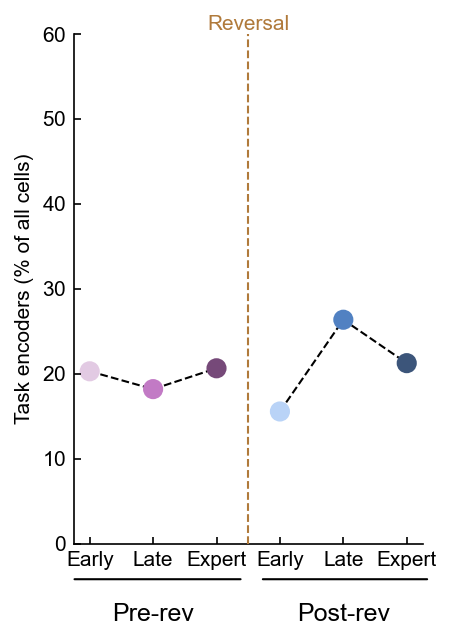

In [25]:
fig, ax = plt.subplots(figsize=(3,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],passive_BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.plot([3,4,5],passive_BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.scatter(range(6),passive_BOTH_allpc_task_encoders*100,fc=PHASE_COLORS,ec=PHASE_COLORS,s=75,label='Stim-only CR')

#ax.set_ylim([0,35])
ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.5
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

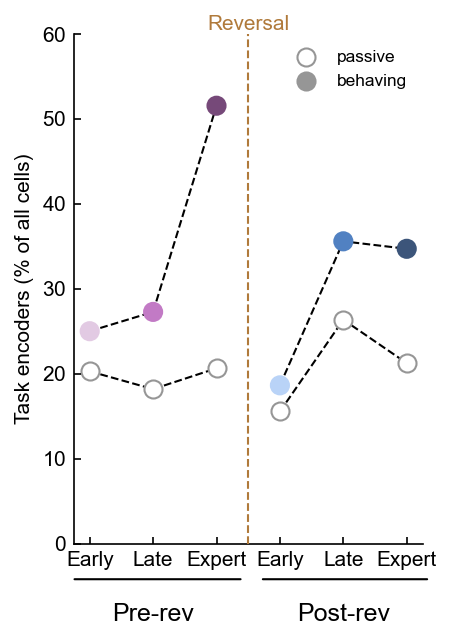

In [30]:
fig, ax = plt.subplots(figsize=(3,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.plot([3,4,5],BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.scatter(range(6),BOTH_allpc_task_encoders*100,fc=PHASE_COLORS,ec=PHASE_COLORS,s=75)

ax.plot([0,1,2],passive_BOTH_allpc_task_encoders[0:3]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.plot([3,4,5],passive_BOTH_allpc_task_encoders[3:6]*100,color='k',linestyle='--',zorder=-1,lw=1)
ax.scatter(range(6),passive_BOTH_allpc_task_encoders*100,fc='white',ec=GOOD_GREY,s=75)

ax.scatter([],[],fc='white',ec=GOOD_GREY,s=75,label='passive')
ax.scatter([],[],c=GOOD_GREY,s=75,label='behaving')








#ax.set_ylim([0,35])
ax.set_ylim([0,60])
ax.set_yticks([0,10,20,30,40,50,60])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.5
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Passive Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

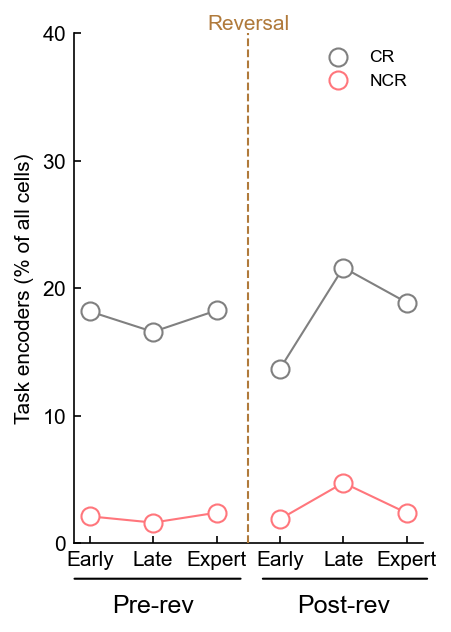

In [37]:
fig, ax = plt.subplots(figsize=(3,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
#chosen_color='#25d964'
labels = ['Early','Late','Expert','Early','Late','Expert']

ax.plot([0,1,2],passive_CR_allpc_task_encoders[0:3]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],passive_CR_allpc_task_encoders[3:6]*100,color=CR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),passive_CR_allpc_task_encoders*100,fc='white',ec=CR_COLOR,s=75,label='CR')

ax.plot([0,1,2],passive_NCR_allpc_task_encoders[0:3]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.plot([3,4,5],passive_NCR_allpc_task_encoders[3:6]*100,color=NCR_COLOR,linestyle='-',zorder=-1,lw=1)
ax.scatter(range(6),passive_NCR_allpc_task_encoders*100,fc='white',ec=NCR_COLOR,s=75,label='NCR')

#ax.set_ylim([0,35])
ax.set_ylim([0,40])
ax.set_yticks([0,10,20,30,40])
ax.set_ylabel('Task encoders (% of all cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.legend(frameon=False)

#This mode
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+1
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(-0.01, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(1.025, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR-NCR Passive Task encoders over learning V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [38]:
TE_Stim_Dec_preearly = []
TE_Stim_Dec_prelate = []
TE_Stim_Dec_preexpert = []
TE_Stim_Dec_postearly = []
TE_Stim_Dec_postlate = []
TE_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if stim_acc < task_encoder_threshold_s:
        continue
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if EILphases[idx] == 'pre early':
        TE_Stim_Dec_preearly.append(stim_acc)
        
    #5,6
    if EILphases[idx] == 'pre late':
        TE_Stim_Dec_prelate.append(stim_acc)
    
    #7,8
    if EILphases[idx] == 'pre expert':
        TE_Stim_Dec_preexpert.append(stim_acc)
        
    #9,10,11,12
    if EILphases[idx] == 'post early':
        TE_Stim_Dec_postearly.append(stim_acc)

    #13,14,15
    if EILphases[idx] == 'post late':
        TE_Stim_Dec_postlate.append(stim_acc)
    
    #16,17,18,19,20,21
    if EILphases[idx] == 'post expert':
        TE_Stim_Dec_postexpert.append(stim_acc)
        
TE_Stim_Dec_preearly = np.array(TE_Stim_Dec_preearly)
TE_Stim_Dec_prelate = np.array(TE_Stim_Dec_prelate)
TE_Stim_Dec_preexpert = np.array(TE_Stim_Dec_preexpert)
TE_Stim_Dec_postearly = np.array(TE_Stim_Dec_postearly)
TE_Stim_Dec_postlate = np.array(TE_Stim_Dec_postlate)
TE_Stim_Dec_postexpert = np.array(TE_Stim_Dec_postexpert)

1830it [00:23, 79.51it/s] 


In [39]:
# TE_Stim_Dec_preearly = []
# TE_Stim_Dec_prelate = []
# TE_Stim_Dec_preexpert = []
# TE_Stim_Dec_postearly = []
# TE_Stim_Dec_postlate = []
# TE_Stim_Dec_postexpert = []

passive_TE_Stim_Dec_preearly = []
passive_TE_Stim_Dec_prelate = []
passive_TE_Stim_Dec_preexpert = []
passive_TE_Stim_Dec_postearly = []
passive_TE_Stim_Dec_postlate = []
passive_TE_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if stim_acc < task_encoder_threshold_p:
        continue
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and ACsessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_TE_Stim_Dec_preearly.append(stim_acc)
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_TE_Stim_Dec_prelate.append(stim_acc)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_TE_Stim_Dec_preexpert.append(stim_acc)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_TE_Stim_Dec_postearly.append(stim_acc)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_TE_Stim_Dec_postlate.append(stim_acc)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_TE_Stim_Dec_postexpert.append(stim_acc)
        
passive_TE_Stim_Dec_preearly = np.array(passive_TE_Stim_Dec_preearly)
passive_TE_Stim_Dec_prelate = np.array(passive_TE_Stim_Dec_prelate)
passive_TE_Stim_Dec_preexpert = np.array(passive_TE_Stim_Dec_preexpert)
passive_TE_Stim_Dec_postearly = np.array(passive_TE_Stim_Dec_postearly)
passive_TE_Stim_Dec_postlate = np.array(passive_TE_Stim_Dec_postlate)
passive_TE_Stim_Dec_postexpert = np.array(passive_TE_Stim_Dec_postexpert)

1442it [00:15, 93.03it/s] 


In [40]:
passive_TE_Stim_Dec_prelate

array([0.60035863, 0.72850833, 0.65283495, 0.57963572, 0.77106964,
       0.93003439, 0.56795125,        nan, 0.69331264, 0.70846421,
              nan, 0.5752779 , 0.58461082, 0.57589444, 0.63398165,
       0.66280678, 0.58838508, 0.63349817, 0.57474648, 0.59724931,
       0.67574138, 0.57115973, 0.57575588, 0.67808288,        nan,
       0.88449033, 0.60439408,        nan, 0.58520594,        nan,
       0.5867882 , 0.58535704, 0.63640268, 0.58313436, 0.62687033,
       0.686831  , 0.81643542, 0.58092448, 0.88633955,        nan,
              nan,        nan,        nan, 0.63249549, 0.79514962,
              nan, 0.61817204, 0.90467815,        nan, 0.58731925,
       0.66055387, 0.82393321, 0.7661821 , 0.60656891,        nan,
       0.57826929, 0.57052873, 0.57985475, 0.62028164, 0.69291778,
       0.61579407, 0.64442677, 0.67868735, 0.60149382, 0.70577484,
       0.66130835, 0.74609129, 0.60039005,        nan])

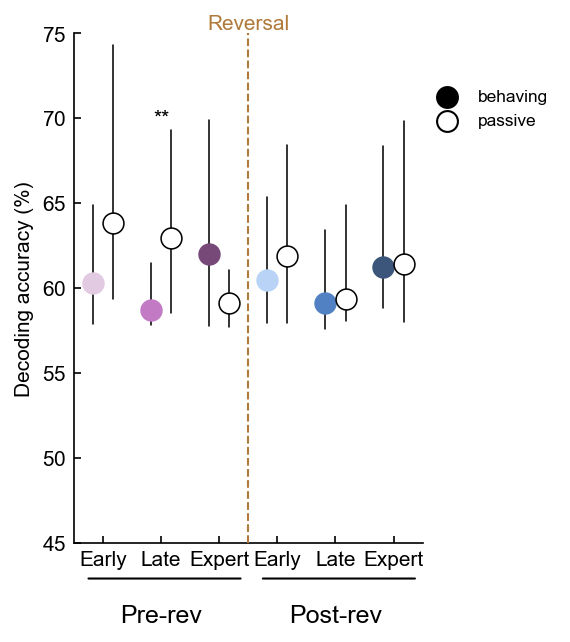

In [53]:
labels = ['Early','Late','Expert','Early','Late','Expert']

fig, ax = plt.subplots(figsize=(3,4.5))
wid = 0.175
    
for idx,(TE_Stim_Dec) in enumerate([TE_Stim_Dec_preearly,TE_Stim_Dec_prelate,TE_Stim_Dec_preexpert,TE_Stim_Dec_postearly,TE_Stim_Dec_postlate,TE_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(TE_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid], [median], c=PHASE_COLORS[idx], s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-wid]*2, [Q1, Q3], c='k', lw=summary_width, zorder=9, solid_capstyle='round')


for idx,(passive_TE_Stim_Dec) in enumerate([passive_TE_Stim_Dec_preearly,passive_TE_Stim_Dec_prelate,passive_TE_Stim_Dec_preexpert,passive_TE_Stim_Dec_postearly,passive_TE_Stim_Dec_postlate,passive_TE_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(passive_TE_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid], [median], ec='k', fc='white', s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid]*2, [Q1, Q3], c='k', lw=summary_width, zorder=9, solid_capstyle='round')

ax.set_xlim([-0.5,5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels)

ax.set_ylim([45,75])
ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylabel('Decoding accuracy (%)')

# ax.text(0,65,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(1,70,str('**'),verticalalignment='center',horizontalalignment='center')
# ax.text(2,75,str('*'),verticalalignment='center',horizontalalignment='center')
# ax.text(3,65,str('*'),verticalalignment='center',horizontalalignment='center')
# ax.text(4,65,str(''),verticalalignment='center',horizontalalignment='center')
# ax.text(5,70,str('**'),verticalalignment='center',horizontalalignment='center')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.15
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[], c='k', s=100,lw=1, zorder=10,label='behaving')
ax.scatter([],[], ec='k',fc='white', s=100,lw=1, zorder=10,label='passive')
lgd = ax.legend(frameon=False,loc=(1,0.8))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','Task encoders decoding accuracy with passive V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

In [50]:
data1 = SimpleNamespace()
data1.preearly = TE_Stim_Dec_preearly
data1.prelate = TE_Stim_Dec_prelate
data1.preexpert = TE_Stim_Dec_preexpert
data1.postearly = TE_Stim_Dec_postearly
data1.postlate = TE_Stim_Dec_postlate
data1.postexpert = TE_Stim_Dec_postexpert

data2 = SimpleNamespace()
data2.preearly = passive_TE_Stim_Dec_preearly
data2.prelate = passive_TE_Stim_Dec_prelate
data2.preexpert = passive_TE_Stim_Dec_preexpert
data2.postearly = passive_TE_Stim_Dec_postearly
data2.postlate = passive_TE_Stim_Dec_postlate
data2.postexpert = passive_TE_Stim_Dec_postexpert

res = ilep.nonparametricIndependentStatsCompareToOther(data1,data2)

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.100320    5.0  0.020064  3.286699  0.006075  0.021899
1          context  0.041508    1.0  0.041508  6.799527  0.009303  0.009179
2  phase * context  0.116288    5.0  0.023258  3.809855  0.002055  0.025296
3         Residual  4.480781  734.0  0.006105       NaN       NaN       NaN

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.501627  0.601952 -0.131573
17  post-expert  A  B  0.954779  0.954779  0.007007
18    post-late  A  B  0.142189  0.213284 -0.347371
19    pre-early  A  B  0.029196  0.087588 -0.418930
20   pre-expert  A  B  0.110506  0.213284  0.651089
21     pre-late  A  B  0.000595  0.003573 -0.719201
